<a href="https://colab.research.google.com/github/raae7742/study-ml-basic/blob/main/9_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 이전 시간의 IMDB 리뷰 데이터셋을 계속 사용할 예정

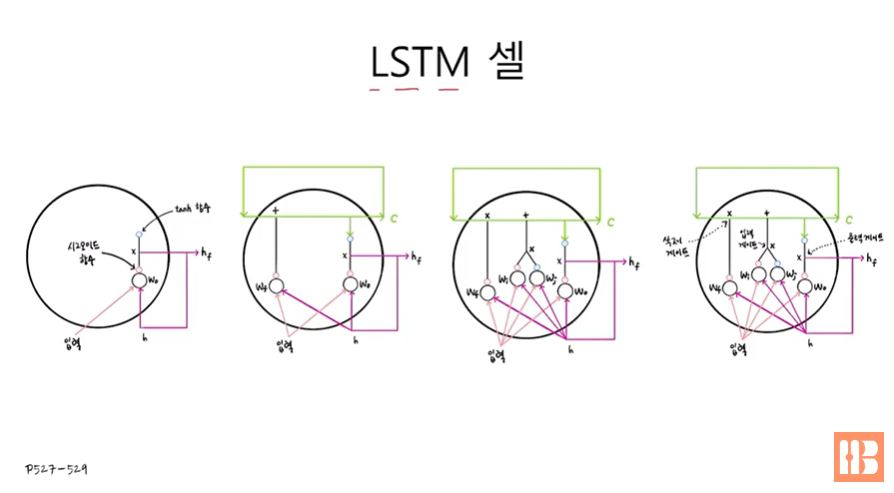

## LSTM 셀
- 순환 신경망의 셀이 이전 타임 스탭의 샘플을 기억하고 있는 것

1. 첫 번째 타임스탭의 출력값인 hf가 그 다음 스탭의 입력값인 h로 다시 사용된다.

2. LSTM 셀은 은닉 상태(hf) 뿐만 아니라 셀 상태(c)도 순환되고 있다.
  - 입력 값과 이전 은닉 상태인 h를 곱해 새로운 셀 상태를 만든다.
  - 최종적으로 두 개의 셀 상태가 만들어진다.

3. 입력과 이전 은닉 상태인 h를 곱해 두 개의 셀 상태가 생성된다. (wi, wj)
  - 각각 시그모이드와 tanh 함수를 통과한다.
  - 셀 상태들은 은닉 상태를 만들기 위해 w0의 tanh 함수를 거치게 된다.

4. 그래프에서 곱해지는 부분들을 gate라고 부른다.
  - 삭제 게이트, 입력 게이트, 출력 게이트

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## LSTM 신경망 훈련하기

In [ ]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [ ]:
# 이전과 모두 동일한 모델이지만 LSTM만 추가됨
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# lstm Params = 4 * (16 * 8 + 8 * 8 + 8) = 800
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 16s 46ms/step - loss: 0.6929 - accuracy: 0.5323 - val_loss: 0.6925 - val_accuracy: 0.5726
Epoch 2/100
313/313 [==============================] - 19s 61ms/step - loss: 0.6919 - accuracy: 0.5972 - val_loss: 0.6912 - val_accuracy: 0.6094
Epoch 3/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6898 - accuracy: 0.6294 - val_loss: 0.6882 - val_accuracy: 0.6416
Epoch 4/100
313/313 [==============================] - 15s 49ms/step - loss: 0.6836 - accuracy: 0.6403 - val_loss: 0.6748 - val_accuracy: 0.6042
Epoch 5/100
313/313 [==============================] - 16s 51ms/step - loss: 0.6516 - accuracy: 0.6451 - val_loss: 0.6272 - val_accuracy: 0.7228
Epoch 6/100
313/313 [==============================] - 18s 56ms/step - loss: 0.6135 - accuracy: 0.7420 - val_loss: 0.6022 - val_accuracy: 0.7450
Epoch 7/100
313/313 [==============================] - 14s 45ms/step - loss: 0.5929 - accuracy: 0.7517 - val_loss: 0.5874 - val_ac

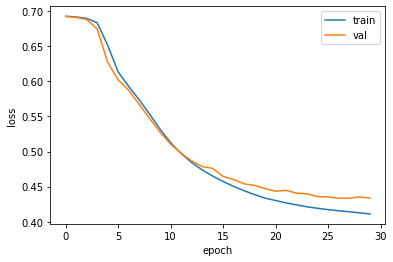

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# SimpleRNN보다 검증 데이터셋의 손실값이 많이 줄어듬

## 순환 층에 드롭아웃 적용하기

In [ ]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
# 드롭아웃을 적용해 과대적합 억제
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 13s 36ms/step - loss: 0.6922 - accuracy: 0.5444 - val_loss: 0.6913 - val_accuracy: 0.5866
Epoch 2/100
313/313 [==============================] - 16s 50ms/step - loss: 0.6895 - accuracy: 0.6078 - val_loss: 0.6876 - val_accuracy: 0.6286
Epoch 3/100
313/313 [==============================] - 17s 53ms/step - loss: 0.6773 - accuracy: 0.6223 - val_loss: 0.6594 - val_accuracy: 0.6374
Epoch 4/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6324 - accuracy: 0.7042 - val_loss: 0.6222 - val_accuracy: 0.7142
Epoch 5/100
313/313 [==============================] - 11s 35ms/step - loss: 0.6041 - accuracy: 0.7265 - val_loss: 0.5985 - val_accuracy: 0.7220
Epoch 6/100
313/313 [==============================] - 11s 35ms/step - loss: 0.5869 - accuracy: 0.7337 - val_loss: 0.5803 - val_accuracy: 0.7422
Epoch 7/100
313/313 [==============================] - 18s 57ms/step - loss: 0.5699 - accuracy: 0.7424 - val_loss: 0.5628 - val_ac

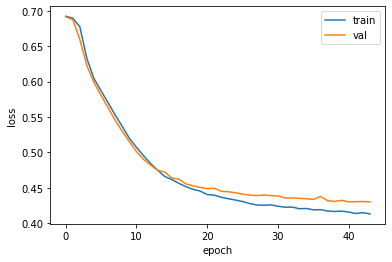

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.legend(['train', 'val'])
plt.show()

# 이전 그래프보다 훨씬 더 손실값이 줄어듬

## 2개의 층을 연결하기
- 여러 개의 순환층을 중첩해 사용할 수 있다.

In [ ]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_length=100))
# return_sequences=True: 순환 은닉 상태를 모든 층에서 출력할 수 있도록 함(False: 마지막 층에서만 은닉 상태 출력)
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 26s 69ms/step - loss: 0.6925 - accuracy: 0.5348 - val_loss: 0.6913 - val_accuracy: 0.6122
Epoch 2/100
313/313 [==============================] - 21s 67ms/step - loss: 0.6879 - accuracy: 0.6148 - val_loss: 0.6814 - val_accuracy: 0.6554
Epoch 3/100
313/313 [==============================] - 21s 67ms/step - loss: 0.6531 - accuracy: 0.6626 - val_loss: 0.6068 - val_accuracy: 0.7054
Epoch 4/100
313/313 [==============================] - 21s 67ms/step - loss: 0.5796 - accuracy: 0.7179 - val_loss: 0.5532 - val_accuracy: 0.7314
Epoch 5/100
313/313 [==============================] - 22s 70ms/step - loss: 0.5356 - accuracy: 0.7473 - val_loss: 0.5168 - val_accuracy: 0.7584
Epoch 6/100
313/313 [==============================] - 21s 67ms/step - loss: 0.5084 - accuracy: 0.7638 - val_loss: 0.4972 - val_accuracy: 0.7678
Epoch 7/100
313/313 [==============================] - 21s 67ms/step - loss: 0.4944 - accuracy: 0.7703 - val_loss: 0.4826 - val_ac

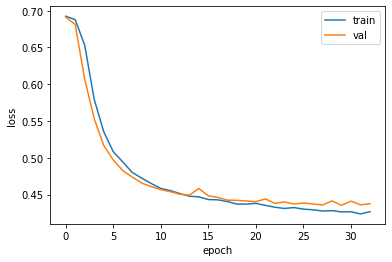

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
# 과대적합이 더 줄어듬
plt.show()

## GRU 신경망 훈련하기

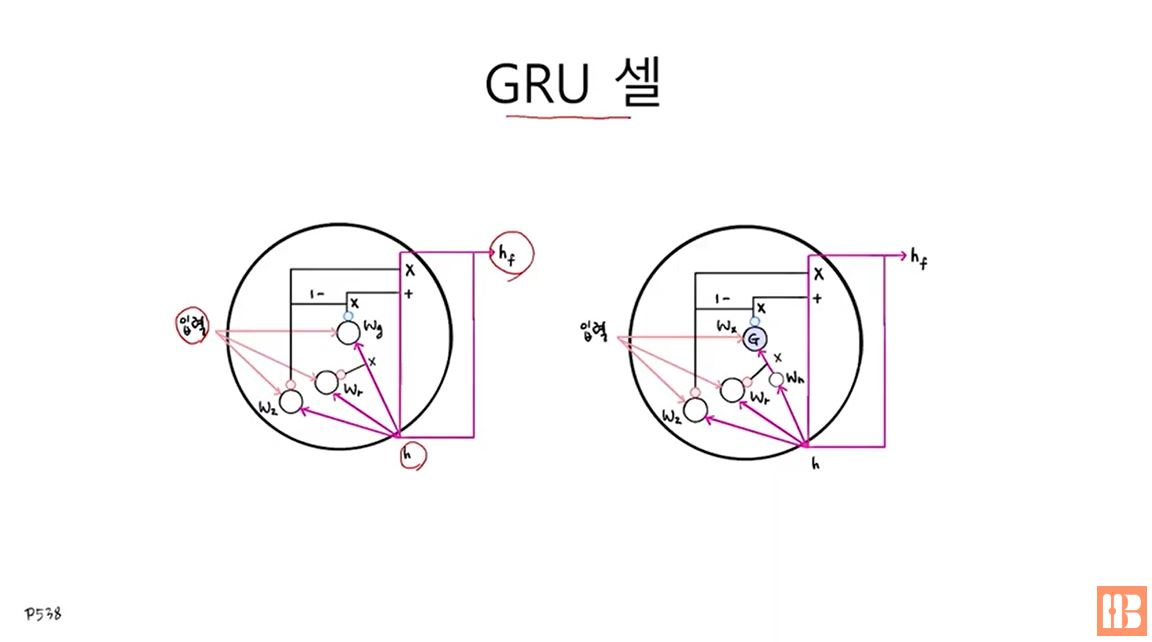

- LSTM 셀의 변종 (간소화 버전)
- 셀 상태가 없고 은닉 상태와 입력만 조합해 출력한다는 특징
- 그림 속의 1- 는 '-1'을 뜻함
- 텐서플로우는 오른쪽 이미지처럼 조금 다른 모습의 셀을 사용하고 있음 (왼쪽이 기본 GRU 셀)
- 텐서플로우의 GRU 셀은 절편이 3개 더 추가된다고 함

In [ ]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_length=100))
# 클래스만 바꾸면 됨
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

# GRU 셀의 파라미터 = (16 * 8 + 8 * 8 + 8) * 3 = 624
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 17s 40ms/step - loss: 0.6918 - accuracy: 0.5375 - val_loss: 0.6907 - val_accuracy: 0.5656
Epoch 2/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6886 - accuracy: 0.5808 - val_loss: 0.6873 - val_accuracy: 0.5856
Epoch 3/100
313/313 [==============================] - 12s 38ms/step - loss: 0.6837 - accuracy: 0.6059 - val_loss: 0.6817 - val_accuracy: 0.6072
Epoch 4/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6757 - accuracy: 0.6232 - val_loss: 0.6725 - val_accuracy: 0.6268
Epoch 5/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6624 - accuracy: 0.6420 - val_loss: 0.6571 - val_accuracy: 0.6442
Epoch 6/100
313/313 [==============================] - 12s 40ms/step - loss: 0.6395 - accuracy: 0.6623 - val_loss: 0.6286 - val_accuracy: 0.6694
Epoch 7/100
313/313 [==============================] - 12s 37ms/step - loss: 0.5935 - accuracy: 0.6938 - val_loss: 0.5715 - val_ac

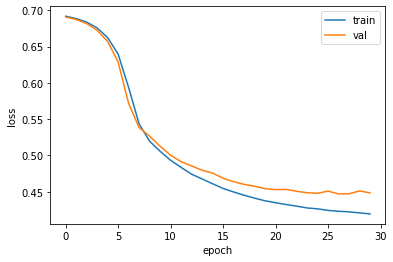

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 마무리

In [ ]:
test_seq = pad_sequences(test_input, maxlen=100)

rnn_model = keras.models.load_model('best-2rnn-model.h5')

rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 10s 11ms/step - loss: 0.4310 - accuracy: 0.7975


[0.43103742599487305, 0.7975199818611145]